## Rankine Cycle using Cantera

In [7]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.optimize import fsolve

In [2]:
w = ct.Water()

In [3]:
def get_TS_saturated(npts=500):
    Tc = w.critical_temperature
    
    Tliq = np.linspace(300.0, Tc-0.1, npts)
    sliq = np.zeros(len(Tliq))
    for i,T in enumerate(Tliq):
        w.TQ = T, 0.0
        sliq[i] = w.entropy_mass
    
    Tvap = np.linspace(Tc-0.1, 300, npts)
    svap = np.zeros(len(Tvap))
    for i,T in enumerate(Tvap):
        w.TQ = T, 1.0
        svap[i] = w.entropy_mass
        
    T = np.hstack([Tliq, Tvap])
    S = np.hstack([sliq, svap])
    return T,S

Tsat,Ssat = get_TS_saturated()


cycle η = 34.4%


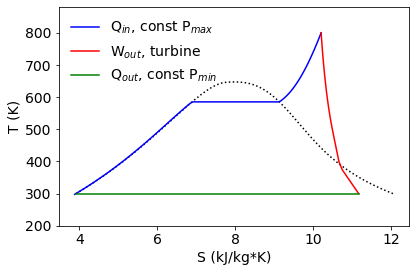

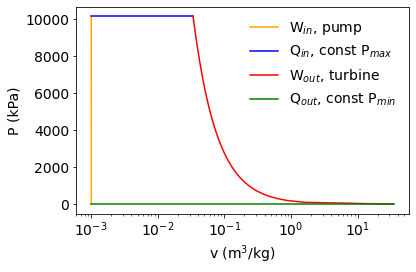

In [10]:
#-------- modified example from Cantera

eta_pump    = 0.6          # pump isentropic efficiency
eta_turbine = 0.8          # turbine isentropic efficiency
Pmax        = 100*101325.0 # Pa
Tmax        = 800.0        # K
T1          = 300.0        # K

#----------- helper functions

def get_S_from_T_satvap(w, T):      # vapor phase
    w.TQ = T, 1.0
    return w.s
def get_T_from_S_satvap(w, s):
    T = fsolve(lambda T: get_S_from_T_satvap(w,T)-s, 300.0)[0]
    return T

def get_S_from_P_satvap(w, P):      # vapor phase
    w.PQ = P, 1.0
    return w.s
def get_P_from_S_satvap(w, s):
    P = fsolve(lambda P: get_S_from_P_satvap(w,P)-s, 1013.0)[0]
    return P

#------------ pump work function (also changes fluid)

def pump(fluid, p_final, eta):
    """Adiabatically pump a fluid to pressure p_final, using
    a pump with isentropic efficiency eta."""
    h0 = fluid.h
    s0 = fluid.s
    fluid.SP = s0, p_final
    h1s = fluid.h
    isentropic_work = h1s - h0
    actual_work = isentropic_work / eta
    h1 = h0 + actual_work
    fluid.HP = h1, p_final
    return actual_work


#------------ turbine work function (also changes fluid)

def turbine(fluid, p_final, eta):
    """Adiabatically expand a fluid to pressure p_final, using
    a turbine with isentropic efficiency eta."""
    h0 = fluid.h
    s0 = fluid.s
    fluid.SP =s0, p_final
    h1s = fluid.h
    isentropic_work = h0 - h1s
    actual_work = isentropic_work * eta
    h1 = h0 - actual_work
    fluid.HP = h1, p_final
    return actual_work

#------- State 1: saturated liquid

w.TQ = T1, 0.0
P1 = w.P
s1 = w.s
h1 = w.enthalpy_mass
v1 = w.v

#------- State 2: pump saturated liquid --> liquid
pump_work = pump(w, Pmax, eta_pump)
T2 = w.T
P2 = w.P
s2 = w.s
h2 = w.h
v2 = w.v

#------- State 3: heat liquid --> saturated vapor, const P

w.PQ = Pmax, 1.0
T3 = w.T
P3 = w.P
s3 = w.s
h3 = w.h
v3 = w.v

#------- State 4: superheat the vapor, const P

w.TP = Tmax, Pmax
T4 = w.T
P4 = w.P
s4 = w.s
h4 = w.h
v4 = w.v

#------- State 5: expanded back to P1

turbine_work = turbine(w, P1, eta_turbine)
T5 = w.T
P5 = w.P
s5 = w.s
h5 = w.h
v5 = w.v

#------- State 6: condense back to all liquid
w.PQ = w.P, 0.0
T6 = w.T
P6 = w.P
s6 = w.s
h6 = w.h
v6 = w.v

#------- efficiency = work out / heat in

work_out = turbine_work-pump_work
heat_in  = h4-h2
η = work_out/heat_in
print(f"cycle η = {η*100:.1f}%")

#--------------- curve between the points

npts = 100

P12 = np.linspace(P1, P2, npts)    # pump: vary p, const s
T12 = np.zeros(npts)
s12 = np.zeros(npts)
v12 = np.zeros(npts)
for i in range(npts):
    w.TQ = T1, 0.0                 # reset w since pump updates it along path
    _ = pump(w, P12[i], eta_pump)
    T12[i] = w.T
    s12[i] = w.s
    v12[i] = w.v

h24 = np.linspace(h1, h4, npts)    # heat: vary h, const p
T24 = np.zeros(npts)
s24 = np.zeros(npts)
v24 = np.zeros(npts)
P24 = np.zeros(npts)
for i in range(npts):
    w.HP = h24[i], P2
    T24[i] = w.T
    s24[i] = w.s
    v24[i] = w.v
    P24[i] = w.P
    
P45 = np.linspace(P4, P1, npts)    # turbine: vary p, const s
T45 = np.zeros(npts)
s45 = np.zeros(npts)
v45 = np.zeros(npts)
for i in range(npts):
    w.TP = T4, P4                  # reset w since turbine updates it along path
    _ = turbine(w, P45[i], eta_turbine)
    T45[i] = w.T
    s45[i] = w.s
    v45[i] = w.v

h56 = np.linspace(h5, h6, npts)    # condense: vary h, const p
T56 = np.zeros(npts)
s56 = np.zeros(npts)
v56 = np.zeros(npts)
P56 = np.zeros(npts)
for i in range(npts):
    w.HP = h56[i], P5
    T56[i] = w.T
    s56[i] = w.s
    v56[i] = w.v
    P56[i] = w.P

#------------- make the plot
    
plt.rc('font', size=14)
plt.plot(Ssat/1000,Tsat, ':', color='black', label='')
plt.plot(s12/1000,T12,   color='orange', label='')
plt.plot(s24/1000,T24,   color='blue',  label=r'Q$_{in}$, const P$_{max}$')
plt.plot(s45/1000,T45,   color='red',   label='W$_{out}$, turbine')
plt.plot(s56/1000,T56,   color='green', label='Q$_{out}$, const P$_{min}$')
plt.ylim([200,1.1*Tmax])
plt.xlabel('S (kJ/kg*K)')
plt.ylabel('T (K)')
plt.legend(frameon=False);
plt.tight_layout()
plt.savefig("rankine1.png");

plt.figure()

plt.plot(v12,P12/1000,   color='orange', label='W$_{in}$, pump')
plt.plot(v24,P24/1000,   color='blue',  label=r'Q$_{in}$, const P$_{max}$')
plt.plot(v45,P45/1000,   color='red',   label='W$_{out}$, turbine')
plt.plot(v56,P56/1000,   color='green', label='Q$_{out}$, const P$_{min}$')
plt.xlabel(r'v (m$^3$/kg)')
plt.ylabel('P (kPa)')
plt.legend(frameon=False);
plt.xscale('log')
plt.tight_layout()
plt.savefig("rankine2.png");